In [1]:
import numpy as np
import tensorflow as tf
import os

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Helper to make the output consistent
SEED = 42
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check TensorFlow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    if not tf.test.is_built_with_cuda():
        print("no cuda")
    else:
        print("yay cuda")

reset_graph()

TensorFlow Version: 1.3.0
No GPU found


Extracting ../mnist_data/train-images-idx3-ubyte.gz
Extracting ../mnist_data/train-labels-idx1-ubyte.gz
Extracting ../mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../mnist_data/t10k-labels-idx1-ubyte.gz


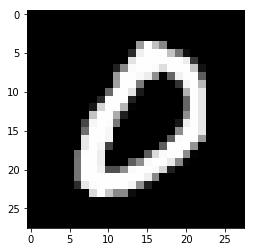

In [2]:
# import dataset (should already be present)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../mnist_data', validation_size=0)

# ------ Make sure we're up and running
# display, random, single image
img = mnist.train.images[np.random.randint(6000, size=1)]

# mnist is 28x28 = 784 and is grayscale
# meaning, the 784 vector needs to be reshaped to 28,28
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [3]:
# activation function
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

In [4]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [8]:
# these are two custom functions adapted from;
# - https://gist.github.com/danijar/8663d3bbfd586bffecf6a0094cd116f2
import functools

def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [9]:
class customModel:
    def __init__(self, build_spec):

        self.build_spec = build_spec
        self.inputs
        self.hidden_block
        self.classifer_block
        self.outputs
        self.cost
        self.optimizer
        self.evaluate
        self.return_init
        #data_size = int(data.get_shape()[1])
        #target_size = int(data.get_shape()[1])
        # assert data_size == target_size


    @define_scope
    def inputs(self):
        self.X = tf.placeholder(tf.float32, shape=(None, 784), name="X")
        self.y = tf.placeholder(tf.int64, shape=(None), name="y")

    @define_scope
    def hidden_block(self):
        with tf.name_scope("dnn"):
            hidden_start = tf.layers.dense(self.X, 448, activation=selu, name="hidden_start")
            hidden_00 = tf.layers.dense(hidden_start, 224, activation=selu)
            self.hidden_end = tf.layers.dense(hidden_00, 112, activation=selu, name="hidden_end")

    @define_scope
    def classifer_block(self):
        classifier_start = tf.layers.dense(self.hidden_end, 64, activation=selu, name="classifier_start")
        classifier_00 = tf.layers.dense(self.hidden_end, 32, activation=selu)
        self.classifier_end = tf.layers.dense(self.hidden_end, 16, activation=selu, name="classifier_end")
    
    @define_scope
    def outputs(self):
        self.logits = tf.layers.dense(self.classifier_end, 10, name="outputs")

    @define_scope
    def cost(self):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits)
        self.loss = tf.reduce_mean(xentropy, name="loss")

    @define_scope
    def optimizer(self):
        optimizer = tf.train.GradientDescentOptimizer(self.build_spec['learning_rate'])
        self.training_op = optimizer.minimize(self.loss)

    @define_scope
    def evaluate(self):
        correct = tf.nn.in_top_k(self.logits, self.y, 1)
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    @define_scope
    def return_init(self):
        self.init_global = tf.global_variables_initializer()
        self.init_local = tf.local_variables_initializer()
        self.saver = tf.train.Saver()

In [10]:
n_epochs = 5
batch_size = 50

def run_model():
    build_dict = {'learning_rate': 0.01}
    model = customModel(build_dict)
    means = mnist.train.images.mean(axis=0, keepdims=True)
    stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10
    
    with tf.Session() as sess:
        model.init_global.run()
        model.init_local.run()
        
        for epoch in range(n_epochs):
            for iteration in range(mnist.train.num_examples // batch_size):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                X_batch_scaled = (X_batch - means) / stds
                sess.run(model.training_op, feed_dict={model.X: X_batch_scaled, model.y: y_batch})

            # metrics
            # acc_train = accuracy.eval()
            acc_train = sess.run(model.accuracy, feed_dict={model.X: X_batch_scaled, model.y: y_batch})
            X_val_scaled = (mnist.test.images - means) / stds
            acc_test = sess.run(model.accuracy, feed_dict={model.X: X_val_scaled, model.y: mnist.test.labels})
            print(epoch, "[top_class] batch train accuracy:", acc_train, "test accuracy:", acc_test)

        save_path = model.saver.save(sess, "./saver/my_model_final_selu.ckpt")

In [11]:
reset_graph()
run_model()

0 [top_class] batch train accuracy: 0.94 test accuracy: 0.9316
1 [top_class] batch train accuracy: 0.94 test accuracy: 0.9453


KeyboardInterrupt: 